Random Forest is performing worse than Logistic Regression. Logistic Regression might be working better because OptimPreproc transforms the dataset in a way that aligns well with linear models like Logistic Regression.  OptimPreproc adjusts the data by linearly shifting data points to reduce bias while minimizing distortion.

In [1]:
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools


# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
preprocessed_dataset = load_preproc_data_adult(['sex'])
train, val_test = preprocessed_dataset.split([0.7], shuffle=True)
val, test = val_test.split([0.5], shuffle=True)

In [3]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.1902
  Disparate Impact: 0.3678

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1910
  Disparate Impact: 0.3740


Probabilistic Transformation:

The method uses a learned probabilistic transformation to alter the dataset.
This transformation adjusts both feature values and labels in a way that minimizes unfair treatment of any protected group while retaining as much of the original data's integrity as possible.


Minimizing Distortion:

A balance is maintained between reducing discrimination and minimizing the distortion of individual data points.
This is crucial for ensuring that the data remains useful and predictive after transformation.

Distortion measures how much the modified data deviates from the original data, which can affect individual data points or the dataset as a whole.

In [4]:
optim_options = {
    "distortion_fun": get_distortion_adult, #measures how much individual data points are modified during the preprocessing.
    "epsilon": 0.1,  #fairness constraint parameter. Lower values of epsilon enforce stricter limits on how much the data can be altered, balancing fairness and data integrity.
    "clist": [0.99, 1.99, 2.99],  #list of fairness cost levels. Each number represents a different level of how much fairness is prioritized. The higher, the more fairness is prioritized
    "dlist": [.1, 0.05, 0] #list of distortion limits corresponding to the fairness costs in clist. At a fairness cost of 0.99, the data can be changed (distorted) up to 0.1.
}

In [5]:
# Initialize OptimPreproc
optim_preproc = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)
# Fit and transform training data
train_transf = optim_preproc.fit_transform(train)
train_transf = train.align_datasets(train_transf)

val_transf = optim_preproc.transform(val)
val_transf = val.align_datasets(val_transf)

test_transf = optim_preproc.transform(test)
test_transf = test.align_datasets(test_transf)


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
c:\Users\festa\AppData\Local\Programs\Python\Python312\L

Optimized Preprocessing: Objective converged to 0.000000


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)


In [6]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")



Train Dataset (After Transformation):
  Statistical Parity Difference: -0.0998
  Disparate Impact: 0.6303

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0992
  Disparate Impact: 0.6398


In [7]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)


Train a classifier with original data.

In [30]:
classifier = RandomForestClassifier(n_estimators=100, random_state=1)



In [31]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] #only for the favorable class?

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    disparate_impact = val_metric.disparate_impact()
    avg_odds_diff = val_metric.average_odds_difference()

    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best Threshold (validation): 0.28
Best Balanced Accuracy (validation): 0.7465983083182731


In [32]:


# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.7425860825671534
Statistical Parity Difference (test): -0.36083940817941984
Disparate Impact (test): 0.27846715427553703
Average Odds Difference (test): -0.320405754313971
Equal Opportunity Difference (test): -0.37754524886877827
Theil Index (test): 0.11304385192843489


In [33]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


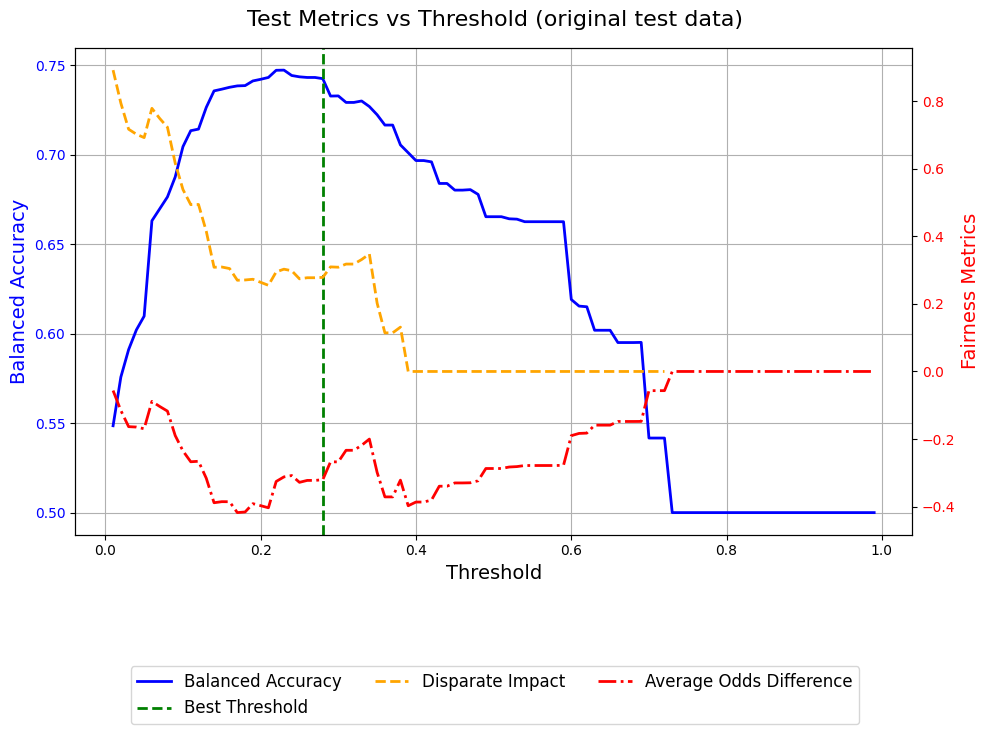

In [34]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

now they are transformed and we train logistic regression on trained data. TRAIN classifier with transformed data.

In [35]:
# Train a classifier on transformed training data
classifier.fit(train_transf.features, train_transf.labels.ravel())


RandomForestClassifier(random_state=1)

In [36]:
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# i shall change all these metrics to _transf
# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.7198457309650119
Statistical Parity Difference (test): -0.21658186887565223
Disparate Impact (test): 0.4371376562290489
Average Odds Difference (test): -0.16382478990147648
Equal Opportunity Difference (test): -0.19977765642065842
Theil Index (test): 0.13431693034516495


In [37]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


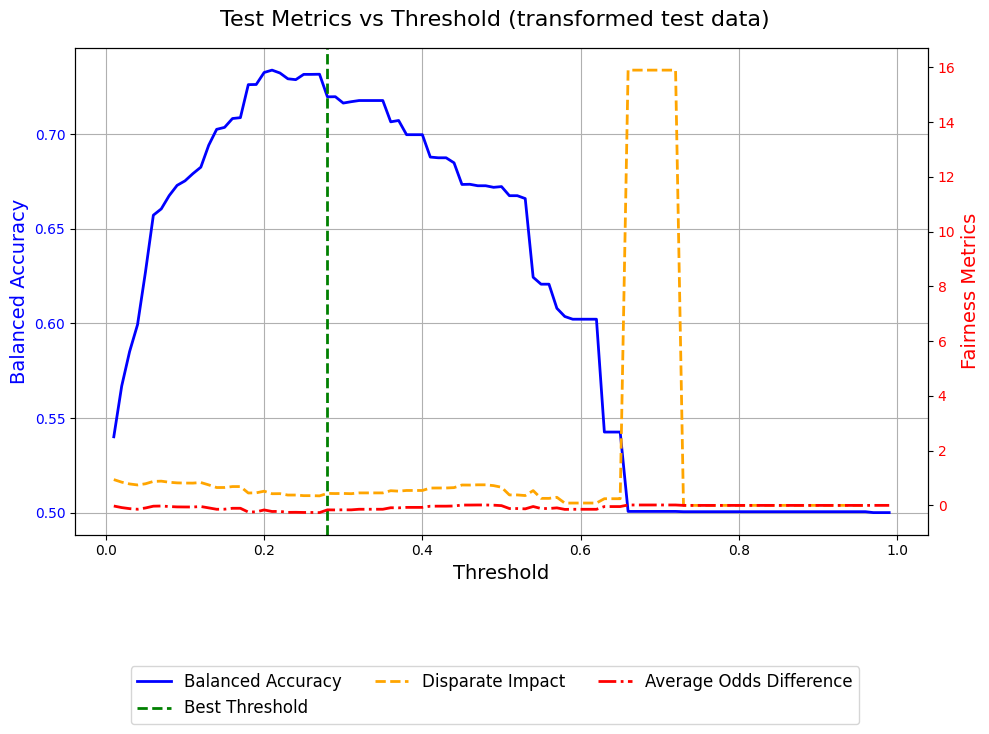

In [38]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [39]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

# Display the table
#display(results_table)


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.


In [40]:

# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)



'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.190244
1,Train,After Transformation,Statistical Parity Difference,-0.099840
2,Test,Before Transformation,Statistical Parity Difference,-0.190984
3,Test,After Transformation,Statistical Parity Difference,-0.099164
4,Train,Before Transformation,Disparate Impact,0.367778
5,Train,After Transformation,Disparate Impact,0.630276
6,Test,Before Transformation,Disparate Impact,0.373983
7,Test,After Transformation,Disparate Impact,0.639846


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.280000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.746598


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.742586
1,Test (Transformed),After Threshold,Balanced Accuracy,0.719846
2,Test (Original),After Threshold,Statistical Parity Difference,-0.360839
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.216582
4,Test (Original),After Threshold,Disparate Impact,0.278467
5,Test (Transformed),After Threshold,Disparate Impact,0.437138
6,Test (Original),After Threshold,Average Odds Difference,-0.320406
7,Test (Transformed),After Threshold,Average Odds Difference,-0.163825
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.377545
9,Test (Transformed),After Threshold,Equal Opportunity Difference,-0.199778
